### Rappel projet match'me
Sur ce projet, l'idée de base étant de trouver si 2 profils peuvent 'match' ensemble, le jeu de donnée devait donc permettre de trouver a partir de caractéristiques de 2 personnes, si elles pouvaient avoir un possibilité de 'match'


### Jeu de donnée speeddating
Le jeu de donnée choisi a été un jeu de donné de speeddating, ou le but étant de faire se rencontrer des personnes et de leur demander leur avis sur leur partenaire pour déterminer si oui ou non il leur convient, malheureusement j'ai trop rapidement essayé des techniques d'exploration et de traitement des données avant de bien être sur que les données soient pleinement compatible avec notre objectif.


### validité de la prédiction
j'ai pris le partis de faire tester les colonnes 'decision' et 'decision_o' en utilisant les informations de 2 profils sur les principaux critères de jugement demandé pour déterminer si les 2 profil pouvaient être mis en relation, cette approche donnait de bon résultat avec des score d'accuracy et AUC a ~80% et des scores de precision/recall > 70%

### Rapprochement avec le projet (et problématiques rencontrées)
Un grand nombre de colonnes ne sont en réalité pas exploitable pour de la rencontre en ligne, il a donc été retiré toutes les colonnes qui ne sont pas récupérable dans notre cas où on cherche a faire match 2 profils qui ne se connaissent pas.

Le problème est qu'en y regardant de plus prêt, beaucoup de colonne importantes pour la prédiction ne sont pas utilisable, les performances de prédiction se sont donc fortement dégradés après leur retrait. (la prediction était quasi identique a une prédiction aléatoire)

il y a également eu confusion sur les colonnes de type `criterion_o` car les colonnes `criterion` et `pref_o_criterion` étant respectivement la notation du profil A et B sur eux même, j'ai compris `criterion_o` comme le pendant de `criterion` ou le profil B se note sur le dit critère mais en réalité ils étaient ceux de `criterion_parner`

Comprendre :
- `criterion` : Comment le profil A se note
- `criterion_important` et `pref_o_criterion` : Respectivement comment les profil A et B accordent de l'importance au critère
- `criterion_partner` et `criterion_o` : Respectivement comment les profil A et B ont noté B et A sur le critère

---

In [4]:
%pip install pandas numpy matplotlib seaborn scipy scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [5]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from scipy.io.arff import MetaData, loadarff
from pandas import DataFrame, Series
from numpy import ndarray
import numpy as np
import pandas as pd
from IPython.display import display, Markdown
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.impute import SimpleImputer
import sys

EPSILON: float = sys.float_info.epsilon
NL='\n'
TAB='\t'

# Récupération et traitement des données (cf. EDA)

In [6]:
# Chargement du jeu de données
data: ndarray
meta: MetaData
data, meta = loadarff('speeddating.arff')

original_df: DataFrame = DataFrame(data)
# Conversion des types des colonnes
for col in original_df.select_dtypes([object]):
    try:
        original_df[col] = original_df[col].astype(int)
    except:
        try:
            original_df[col] = original_df[col].astype(float)
        except:
            original_df[col] = original_df[col].astype(str)

# Correction des noms de colonnes
original_df.rename(
    columns={
        'sinsere_o': 'sincere_o',
        'intellicence_important': 'intelligence_important',
        'ambition': 'ambitious',
        'ambtition_important': 'ambitious_important',
        'ambition_partner': 'ambitious_partner',
        'ambitous_o': 'ambitious_o'
    },
    inplace=True
)

# Récupération des colonnes utiles
columns: list[str] = ['age', 'age_o', 'ambitious', 'ambitious_important', 'ambitious_o', 'ambitious_partner',
                      'art', 'attractive', 'attractive_important', 'attractive_o', 'attractive_partner',
                      'clubbing', 'concerts', 'd_age', 'decision', 'decision_o', 'dining', 'exercise',
                      'expected_happy_with_sd_people', 'expected_num_matches', 'funny', 'funny_important',
                      'funny_o', 'funny_partner', 'gaming', 'gender', 'guess_prob_liked', 'hiking',
                      'importance_same_race', 'importance_same_religion', 'intelligence', 'intelligence_important',
                      'intelligence_o', 'intelligence_partner', 'interests_correlate', 'like', 'match',
                      'met', 'movies', 'music', 'pref_o_ambitious', 'pref_o_attractive', 'pref_o_funny',
                      'pref_o_intelligence', 'pref_o_shared_interests', 'pref_o_sincere', 'race', 'race_o',
                      'reading', 'samerace', 'shared_interests_important', 'shared_interests_o',
                      'shared_interests_partner', 'shopping', 'sincere', 'sincere_important', 'sincere_o',
                      'sincere_partner', 'sports', 'theater', 'tv', 'tvsports', 'yoga' ]
df: DataFrame = original_df[columns].copy()

# Remplacement des catégories '?' par 'Other'
df.loc[df['race'] == '?', 'race'] = 'Other'
df.loc[df['race_o'] == '?', 'race_o'] = 'Other'

# Bornage des valeurs a 10 dans les activités 'gaming' et 'reading'
df.loc[df['gaming'] > 10, 'gaming'] = 10
df.loc[df['reading'] > 10, 'reading'] = 10

# Correction des valeurs d'ages
df.loc[df['age_o'].isna() & df['age'].notna(), 'd_age'] = float('nan')
df.loc[df['age_o'].notna() & df['age'].isna(), 'd_age'] = float('nan')
df.loc[df['age_o'].isna() & df['age'].isna(), 'd_age'] = float('nan')

mean_d_age: float = df['d_age'].describe()['mean']
df.loc[df['d_age'].isna(), 'd_age'] = mean_d_age

mean_age: float = df['age'].describe()['mean']
df.loc[df['age_o'].isna() & df['age'].notna(), 'age_o'] = df['age'] + df['d_age']
df.loc[df['age_o'].notna() & df['age'].isna(), 'age'] = df['age_o'] + df['d_age']
df.loc[df['age_o'].isna() & df['age'].isna(), ['age', 'age_o']] = [mean_age, mean_age + mean_d_age]

# df = pd.concat([df.loc[df['match'] == 1], df.loc[df['match'] == 0].sample(frac=.5)])
# df.sort_index(inplace=True)

# Imputation des données (cf. ml_impute)

In [7]:
transformer = ColumnTransformer(
    transformers=[
		('race', SimpleImputer(strategy='constant', fill_value='Other'), ['race', 'race_o']),
		('hobbies', SimpleImputer(strategy='constant', fill_value=0), ['art', 'clubbing', 'concerts', 'dining', 'exercise', 'gaming', 'hiking', 'movies', 'music', 'reading', 'shopping', 'sports', 'theater', 'tv', 'tvsports', 'yoga']),
		('met', SimpleImputer(strategy='most_frequent'), ['met']),
		('criterion', SimpleImputer(strategy='mean'), ['sincere', 'sincere_partner', 'sincere_o', 'pref_o_sincere', 'sincere_important', 'funny', 'funny_partner', 'funny_o', 'pref_o_funny', 'funny_important', 'attractive', 'attractive_partner', 'attractive_o', 'pref_o_attractive', 'attractive_important', 'ambitious', 'ambitious_partner', 'ambitious_o', 'pref_o_ambitious', 'ambitious_important', 'intelligence', 'intelligence_partner', 'intelligence_o', 'pref_o_intelligence', 'intelligence_important', 'shared_interests_partner', 'shared_interests_o', 'pref_o_shared_interests', 'shared_interests_important']),
		('importance_race_religion', SimpleImputer(strategy='mean'), ['importance_same_race', 'importance_same_religion']),
		('remains', SimpleImputer(strategy='mean'), ['expected_happy_with_sd_people', 'expected_num_matches', 'guess_prob_liked', 'like', 'interests_correlate']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform="pandas")

In [8]:
encoders = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(sparse_output=False, drop="if_binary"), [ 'race', 'race_o', 'gender']) # type: ignore
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform="pandas")

# Entrainement des modèles

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

def plots(model, X_test: DataFrame, y_test: Series):
    # Assure que le model passé en paramètre est compativle avec la méthode predict_proba
    if not hasattr(model, 'predict_proba'):
        raise ValueError("'model' must have predict_proba method")
    
    # Assure que le model passé en paramètre est compativle avec la méthode predict
    if not hasattr(model, 'predict'):
        raise ValueError("'model' must have predict method")
    
    # Réalisation des prédictions
    y_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)

    # Affichage du raport
    print(classification_report(y_test, y_pred))
    
    # Affichage de la patrice de confusion
    fig: Figure
    ax_cm: Axes
    ax_roc: Axes
    ax_01: Axes
    ax_1: Axes

    fig, ((ax_cm, ax_roc), (ax_01, ax_1)) = plt.subplots(2,2, figsize=(10,10))
    fig.suptitle(model.__repr__())

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot(ax=ax_cm)

    # Recherche des TP/FP/TN/FN en fonction du seuil
    real_pred_df: DataFrame = DataFrame(
        columns=[
            'thresold',
            'TP0',
            'FP0',
            'TN0',
            'FN0',
            'TP1',
            'FP1',
            'TN1',
            'FN1'
        ]
    )

    for i in range(100+1):
        ratio = i/100
        real_pred_df.loc[i] = [
            ratio,
            ((y_test == 0) & (y_test_proba[:,0] > ratio)).sum(),
            ((y_test == 1) & (y_test_proba[:,0] > ratio)).sum(),
            ((y_test == 1) & (y_test_proba[:,0] <= ratio)).sum(),
            ((y_test == 0) & (y_test_proba[:,0] <= ratio)).sum(),
            ((y_test == 1) & (y_test_proba[:,1] > ratio)).sum(),
            ((y_test == 0) & (y_test_proba[:,1] > ratio)).sum(),
            ((y_test == 0) & (y_test_proba[:,1] <= ratio)).sum(),
            ((y_test == 1) & (y_test_proba[:,1] <= ratio)).sum(),
        ]

    score_df: DataFrame = DataFrame()
    score_df['recall 0'] = real_pred_df['TP0'] / (real_pred_df['TP0'] + real_pred_df['FN0'])
    score_df['precision 0'] = real_pred_df['TP0'] / (real_pred_df['TP0'] + real_pred_df['FP0'])
    score_df['accuracy 0'] = real_pred_df[['TP0', 'TN0']].sum(axis=1) / len(y_test)
    score_df['recall 1'] = real_pred_df['TP1'] / (real_pred_df['TP1'] + real_pred_df['FN1'])
    score_df['precision 1'] = real_pred_df['TP1'] / (real_pred_df['TP1'] + real_pred_df['FP1'])
    score_df['accuracy 1'] = real_pred_df[['TP1', 'TN1']].sum(axis=1) / len(y_test)
    
    score_df.plot.line(color=['orange', 'brown', 'red', 'cyan', 'lime', 'blue'], ax=ax_01)
    score_df[['recall 1', 'precision 1', 'accuracy 1']].plot.line(color=['cyan', 'lime', 'blue'], ax=ax_1)
    ax_01.set_xlabel('seuil %')
    ax_01.set_ylabel('score [0-1]')
    ax_1.set_xlabel('seuil %')
    ax_1.set_ylabel('score [0-1]')
    ax_01.axvline(x=50, color='green', linestyle='--')
    ax_1.axvline(x=50, color='green', linestyle='--')
    for y in range(1,9+1):
        ax_01.axhline(y=y/10, color='lightgray', linestyle='--')
        ax_1.axhline(y=y/10, color='lightgray', linestyle='--')

    # courbe ROC et score AUC
    auc = roc_auc_score(y_test, y_test_proba[:,1])
    fpr, tpr, _ = roc_curve(y_test, y_test_proba[:,1])
    ax_roc.plot(fpr, tpr, color='blue')
    ax_roc.plot([0, 1], [0, 1], color='red', linestyle='--')
    ax_roc.set_title(f'AUC {auc:.2f}')
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')

    plt.show()

In [10]:
preprocess_pipeline: Pipeline = Pipeline([
    ('impute', transformer),
    ('encoders', encoders)
])

preprocessed_df: DataFrame = preprocess_pipeline.fit_transform(df) # type: ignore

In [11]:
from sklearn.model_selection import train_test_split

preprocessed_df: DataFrame = preprocess_pipeline.fit_transform(df) # type: ignore
preprocessed_df_X: DataFrame = preprocessed_df[preprocessed_df.columns.difference(['match', 'decision', 'decision_o'])]

categorical_columns: list[str] = preprocessed_df.loc[:,((preprocessed_df == 0) + (preprocessed_df == 1)).all()].columns.tolist()
continue_columns: list[str] = preprocessed_df.columns.difference(categorical_columns).tolist()

In [12]:
preprocessed_df_y: Series = preprocessed_df['decision']

X_train: DataFrame
X_test: DataFrame
y_train: Series
y_test: Series

X_train, X_test, y_train, y_test = train_test_split(
    preprocessed_df_X,
    preprocessed_df_y,
    test_size=0.2,
    stratify=preprocessed_df_y,
    random_state=42
)

X_scaled_train: DataFrame = X_train.copy()
X_scaled_test: DataFrame = X_test.copy()
X_scaled_train[continue_columns] = StandardScaler().fit_transform(X_train[continue_columns])
X_scaled_test[continue_columns] = StandardScaler().fit_transform(X_test[continue_columns])

## Modèle de régression logistique

Réalisation de la prédiction sur un jeu de colonne qui peut être récupéré ou calculé pour une comparaison de profil en ligne

|                     |   weight |
|:--------------------|---------:|
| gaming              | 0.1883   |
| pref_o_ambitious    | 0.130316 |
| interests_correlate | 0.120622 |
| yoga                | 0.114179 |
| reading             | 0.102297 |

|                         |     weight |
|:------------------------|-----------:|
| pref_o_sincere          | -0.0794491 |
| shopping                | -0.0817826 |
| pref_o_shared_interests | -0.119121  |
| exercise                | -0.127109  |
| movies                  | -0.135265  |

              precision    recall  f1-score   support

           0       0.61      0.83      0.70       972
           1       0.53      0.27      0.35       704

    accuracy                           0.59      1676
   macro avg       0.57      0.55      0.53      1676
weighted avg       0.57      0.59      0.55      1676



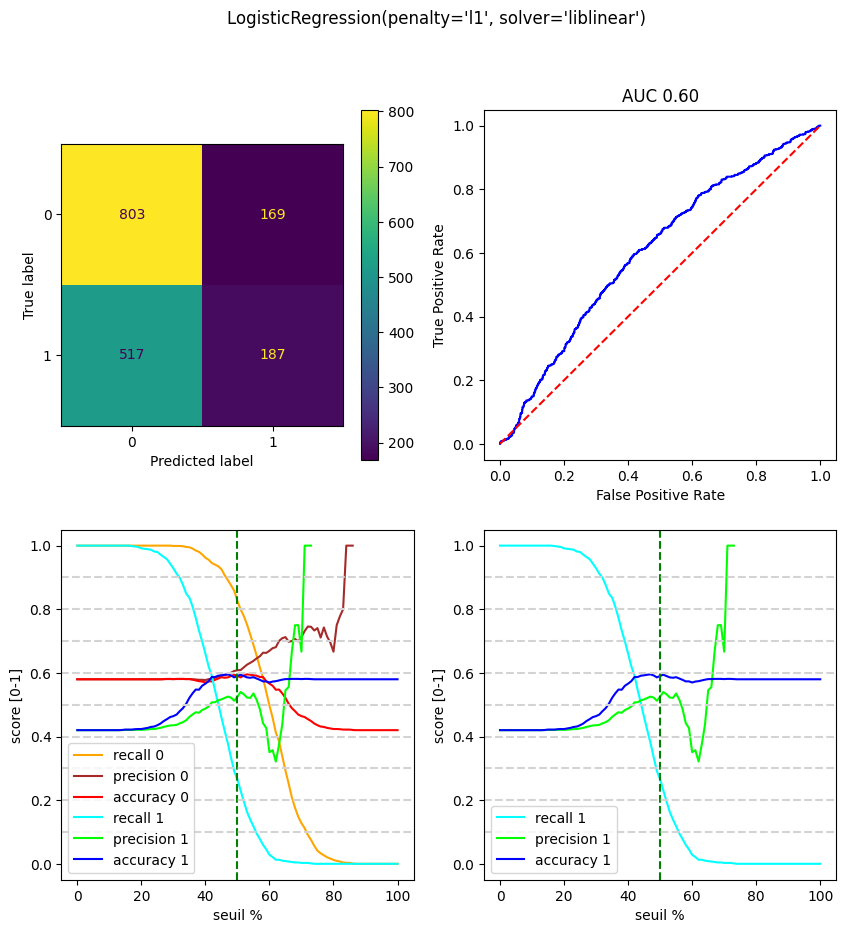

In [13]:
# Pour les besoins fonctionnels certaines informations ne peuvent pas etre récupérées
keep_columns = [
    'age', 'age_o', 'd_age',
    'sports', 'tvsports', 'exercise', 'dining', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga',
    'interests_correlate',
    'attractive_important', 'sincere_important', 'intelligence_important', 'funny_important', 'ambitious_important', 'shared_interests_important', # score du profil A sur A
    'pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests', # score du profil B sur B
    # Ces colonnes sont prépondérante mais ne peuvent pas être demandées
    # 'attractive_o', 'sincere_o', 'intelligence_o', 'funny_o', 'ambitious_o', 'shared_interests_o', # score du profil B sur A
    # 'attractive_partner', 'sincere_partner', 'intelligence_partner', 'funny_partner', 'ambitious_partner', 'shared_interests_partner', # score du profil A sur B
    # 'expected_happy_with_sd_people', 'expected_num_matches', 'like', 'guess_prob_liked', 'met'
]

log_reg: LogisticRegression = LogisticRegression(
    solver="liblinear",
    penalty="l1"
)

log_reg.fit(X_scaled_train[keep_columns], y_train)
log_reg.score(X_scaled_train[keep_columns], y_train)
log_reg.score(X_scaled_test[keep_columns], y_test)

feature_weight_match: DataFrame = DataFrame(log_reg.coef_.T, index=keep_columns, columns=['weight'])
feature_weight_match = feature_weight_match.loc[feature_weight_match['weight'] != 0].sort_values('weight', ascending=False)
display(
    Markdown(feature_weight_match.head(5).to_markdown()),
    Markdown(feature_weight_match.tail(5).to_markdown()),
)

plots(log_reg, X_scaled_test[keep_columns], y_test)

---

Réalisation de la prédiction sur toutes les colonnes conservées après l'EDA pour comparaison

|                      |   weight |
|:---------------------|---------:|
| like                 | 1.04532  |
| attractive_partner   | 0.805592 |
| guess_prob_liked     | 0.451026 |
| expected_num_matches | 0.424005 |
| funny_partner        | 0.343596 |

|                                  |    weight |
|:---------------------------------|----------:|
| attractive                       | -0.233869 |
| ambitious_partner                | -0.251033 |
| attractive_o                     | -0.273623 |
| sincere_partner                  | -0.291306 |
| race_European/Caucasian-American | -0.46018  |

              precision    recall  f1-score   support

           0       0.82      0.83      0.83       972
           1       0.76      0.75      0.75       704

    accuracy                           0.80      1676
   macro avg       0.79      0.79      0.79      1676
weighted avg       0.80      0.80      0.80      1676



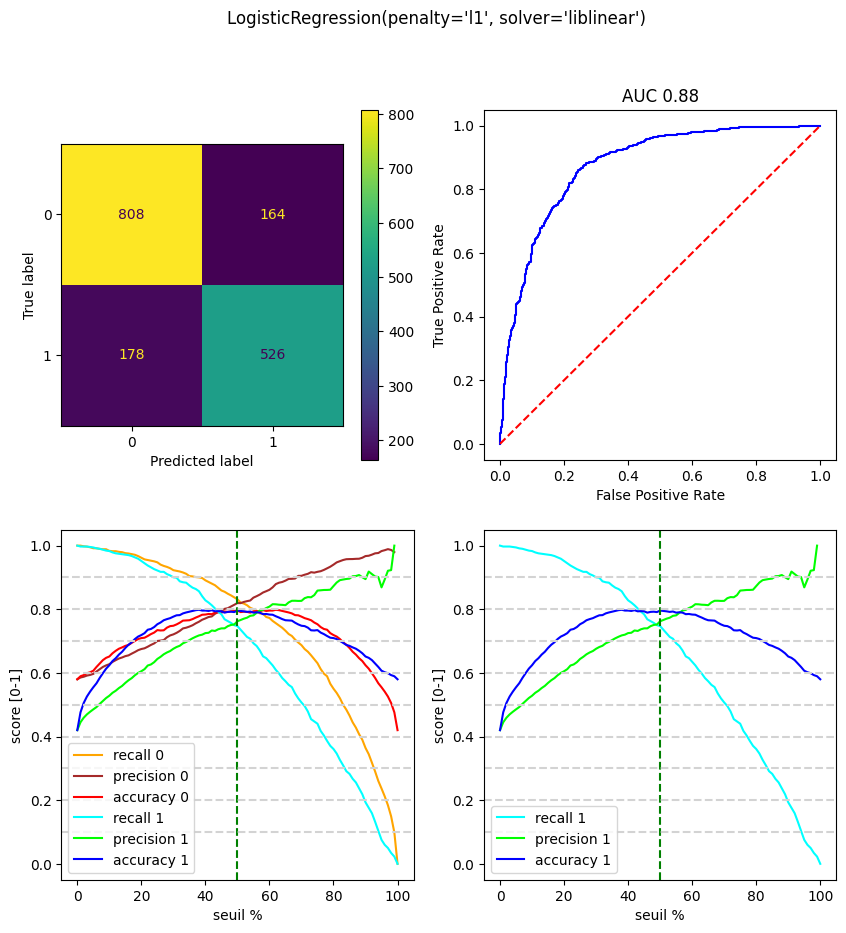

In [14]:
log_reg: LogisticRegression = LogisticRegression(
    solver="liblinear",
    penalty="l1"
)

log_reg.fit(X_scaled_train, y_train)
log_reg.score(X_scaled_train, y_train)
log_reg.score(X_scaled_test, y_test)

feature_weight_match: DataFrame = DataFrame(log_reg.coef_.T, index=X_train.columns, columns=['weight'])
feature_weight_match = feature_weight_match.loc[feature_weight_match['weight'] != 0].sort_values('weight', ascending=False)
display(
    Markdown(feature_weight_match.head(5).to_markdown()),
    Markdown(feature_weight_match.tail(5).to_markdown()),
)

plots(log_reg, X_scaled_test, y_test)

---
---

Divers autres tests en réincluant des colonnes

|                    |   weight |
|:-------------------|---------:|
| gaming             | 0.16998  |
| pref_o_attractive  | 0.141755 |
| shared_interests_o | 0.13472  |
| sincere_o          | 0.132648 |
| pref_o_ambitious   | 0.129217 |

|                         |     weight |
|:------------------------|-----------:|
| ambitious_important     | -0.0694797 |
| pref_o_shared_interests | -0.0863825 |
| exercise                | -0.105718  |
| movies                  | -0.143043  |
| attractive_o            | -0.315655  |

              precision    recall  f1-score   support

           0       0.62      0.81      0.70       972
           1       0.55      0.33      0.41       704

    accuracy                           0.61      1676
   macro avg       0.59      0.57      0.56      1676
weighted avg       0.59      0.61      0.58      1676



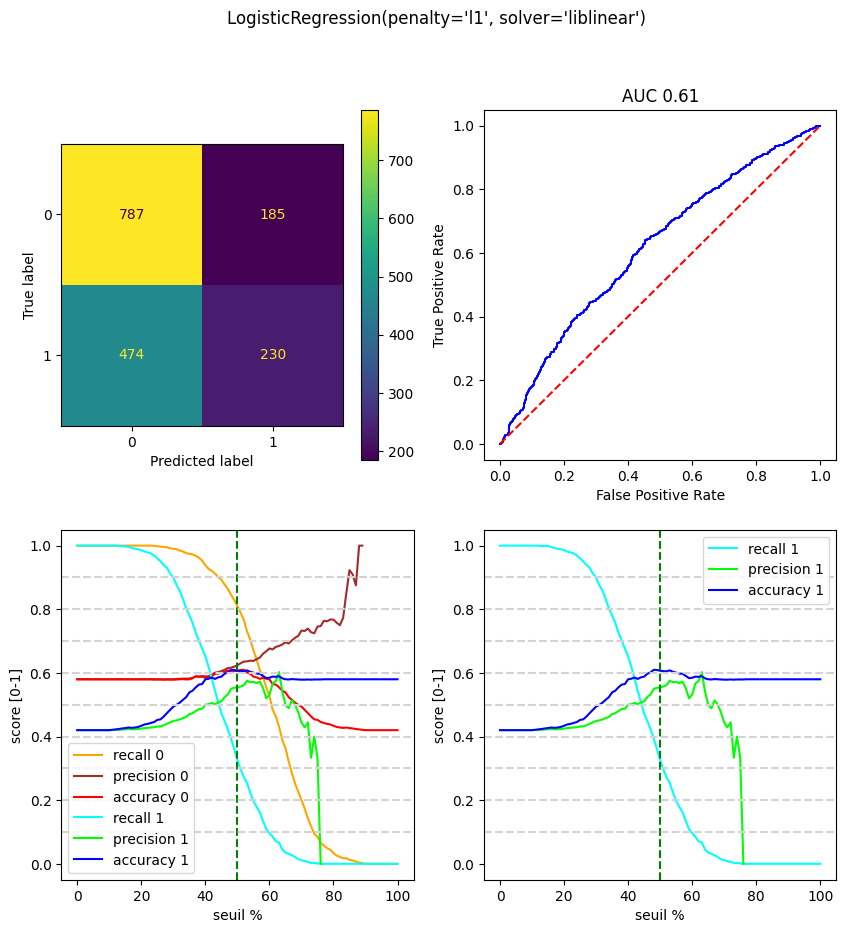

In [15]:
# Pour les besoins fonctionnels certaines informations ne peuvent pas etre récupérées
keep_columns = [
    'age', 'age_o', 'd_age',
    'sports', 'tvsports', 'exercise', 'dining', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga',
    'interests_correlate',
    'attractive_important', 'sincere_important', 'intelligence_important', 'funny_important', 'ambitious_important', 'shared_interests_important', # score du profil A sur A
    'pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests', # score du profil B sur B
    # Ces colonnes sont prépondérante mais ne peuvent pas être demandées
    'attractive_o', 'sincere_o', 'intelligence_o', 'funny_o', 'ambitious_o', 'shared_interests_o', # score du profil B sur A
    # 'attractive_partner', 'sincere_partner', 'intelligence_partner', 'funny_partner', 'ambitious_partner', 'shared_interests_partner', # score du profil A sur B
    # 'expected_happy_with_sd_people', 'expected_num_matches', 'like', 'guess_prob_liked', 'met'
]

log_reg: LogisticRegression = LogisticRegression(
    solver="liblinear",
    penalty="l1"
)

log_reg.fit(X_scaled_train[keep_columns], y_train)
log_reg.score(X_scaled_train[keep_columns], y_train)
log_reg.score(X_scaled_test[keep_columns], y_test)

feature_weight_match: DataFrame = DataFrame(log_reg.coef_.T, index=keep_columns, columns=['weight'])
feature_weight_match = feature_weight_match.loc[feature_weight_match['weight'] != 0].sort_values('weight', ascending=False)
display(
    Markdown(feature_weight_match.head(5).to_markdown()),
    Markdown(feature_weight_match.tail(5).to_markdown()),
)

plots(log_reg, X_scaled_test[keep_columns], y_test)

|                            |   weight |
|:---------------------------|---------:|
| attractive_partner         | 1.0132   |
| funny_partner              | 0.569872 |
| shared_interests_partner   | 0.545135 |
| pref_o_attractive          | 0.176359 |
| shared_interests_important | 0.172881 |

|                   |     weight |
|:------------------|-----------:|
| sincere_partner   | -0.0980869 |
| shopping          | -0.116582  |
| movies            | -0.131629  |
| attractive_o      | -0.263998  |
| ambitious_partner | -0.26496   |

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       972
           1       0.74      0.69      0.71       704

    accuracy                           0.77      1676
   macro avg       0.76      0.75      0.76      1676
weighted avg       0.76      0.77      0.76      1676



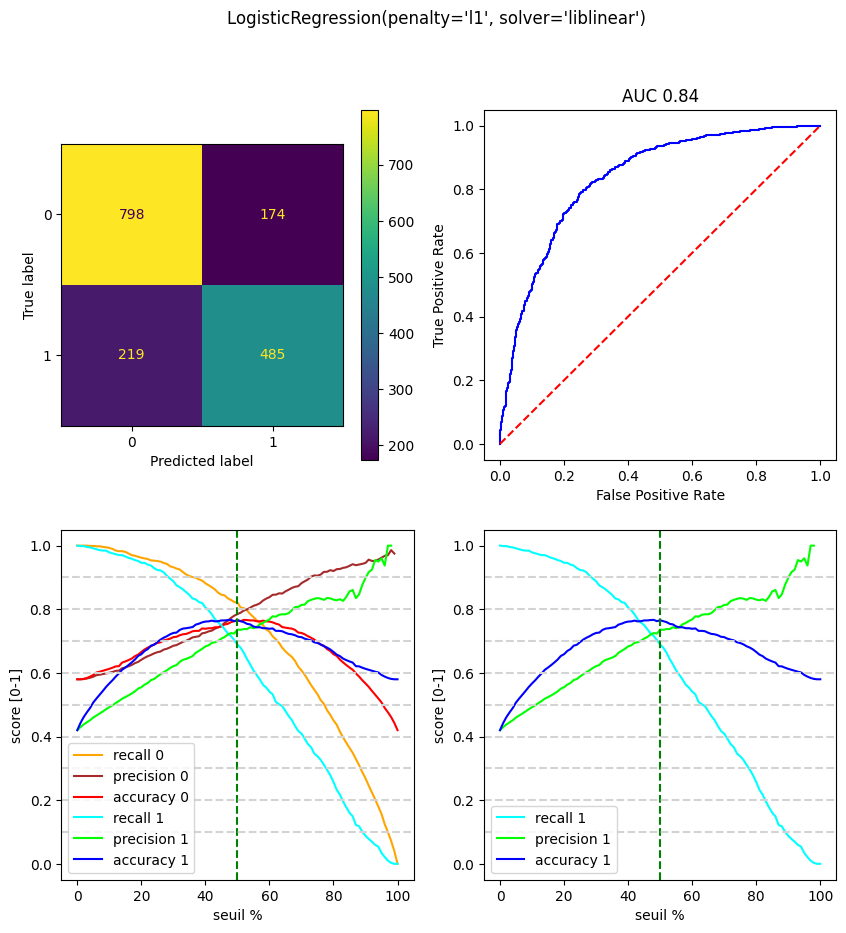

In [16]:
# Pour les besoins fonctionnels certaines informations ne peuvent pas etre récupérées
keep_columns = [
    'age', 'age_o', 'd_age',
    'sports', 'tvsports', 'exercise', 'dining', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga',
    'interests_correlate',
    'attractive_important', 'sincere_important', 'intelligence_important', 'funny_important', 'ambitious_important', 'shared_interests_important', # score du profil A sur A
    'pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests', # score du profil B sur B
    # Ces colonnes sont prépondérante mais ne peuvent pas être demandées
    'attractive_o', 'sincere_o', 'intelligence_o', 'funny_o', 'ambitious_o', 'shared_interests_o', # score du profil B sur A
    'attractive_partner', 'sincere_partner', 'intelligence_partner', 'funny_partner', 'ambitious_partner', 'shared_interests_partner', # score du profil A sur B
    # 'expected_happy_with_sd_people', 'expected_num_matches', 'like', 'guess_prob_liked', 'met'
]

log_reg: LogisticRegression = LogisticRegression(
    solver="liblinear",
    penalty="l1"
)

log_reg.fit(X_scaled_train[keep_columns], y_train)
log_reg.score(X_scaled_train[keep_columns], y_train)
log_reg.score(X_scaled_test[keep_columns], y_test)

feature_weight_match: DataFrame = DataFrame(log_reg.coef_.T, index=keep_columns, columns=['weight'])
feature_weight_match = feature_weight_match.loc[feature_weight_match['weight'] != 0].sort_values('weight', ascending=False)
display(
    Markdown(feature_weight_match.head(5).to_markdown()),
    Markdown(feature_weight_match.tail(5).to_markdown()),
)

plots(log_reg, X_scaled_test[keep_columns], y_test)

|                      |   weight |
|:---------------------|---------:|
| like                 | 1.4814   |
| expected_num_matches | 0.411175 |
| guess_prob_liked     | 0.276908 |
| gaming               | 0.16746  |
| yoga                 | 0.157563 |

|              |    weight |
|:-------------|----------:|
| movies       | -0.101659 |
| exercise     | -0.112596 |
| sports       | -0.117356 |
| shopping     | -0.179508 |
| attractive_o | -0.40265  |

              precision    recall  f1-score   support

           0       0.78      0.81      0.80       972
           1       0.73      0.68      0.70       704

    accuracy                           0.76      1676
   macro avg       0.75      0.75      0.75      1676
weighted avg       0.76      0.76      0.76      1676



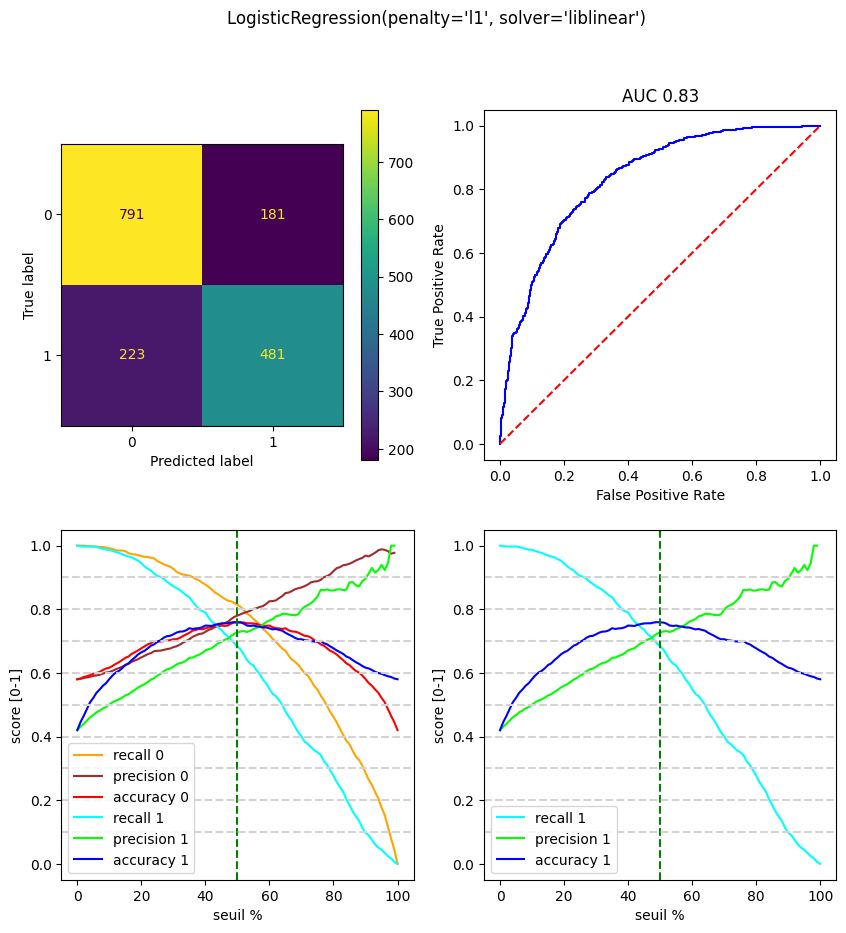

In [17]:
# Pour les besoins fonctionnels certaines informations ne peuvent pas etre récupérées
keep_columns = [
    'age', 'age_o', 'd_age',
    'sports', 'tvsports', 'exercise', 'dining', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga',
    'interests_correlate',
    'attractive_important', 'sincere_important', 'intelligence_important', 'funny_important', 'ambitious_important', 'shared_interests_important', # score du profil A sur A
    'pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests', # score du profil B sur B
    # Ces colonnes sont prépondérante mais ne peuvent pas être demandées
    'attractive_o', 'sincere_o', 'intelligence_o', 'funny_o', 'ambitious_o', 'shared_interests_o',
    #'attractive_partner', 'sincere_partner', 'intelligence_partner', 'funny_partner', 'ambitious_partner', 'shared_interests_partner',
    'expected_happy_with_sd_people', 'expected_num_matches', 'like', 'guess_prob_liked', 'met'
]

log_reg: LogisticRegression = LogisticRegression(
    solver="liblinear",
    penalty="l1"
)

log_reg.fit(X_scaled_train[keep_columns], y_train)
log_reg.score(X_scaled_train[keep_columns], y_train)
log_reg.score(X_scaled_test[keep_columns], y_test)

feature_weight_match: DataFrame = DataFrame(log_reg.coef_.T, index=keep_columns, columns=['weight'])
feature_weight_match = feature_weight_match.loc[feature_weight_match['weight'] != 0].sort_values('weight', ascending=False)
display(
    Markdown(feature_weight_match.head(5).to_markdown()),
    Markdown(feature_weight_match.tail(5).to_markdown()),
)

plots(log_reg, X_scaled_test[keep_columns], y_test)